In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,f1_score
import joblib
import lightgbm as lgb
import numpy as np
from sklearn.preprocessing import StandardScaler
import ta  # Technical Analysis library
from sklearn.ensemble import VotingRegressor

In [2]:
pip install ta

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29421 sha256=41a9e2b66ef0dc08aa927b1da533a6457d8099dc95c0767ea43e6dc7f55f1305
  Stored in directory: c:\users\94537\appdata\local\pip\cache\wheels\12\a5\37\d70c44e37fb42f45f8c1c38dd479f98fd3b357e86e0780e311
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Import file
# Read the CSV file
file_path1 = 'trade_data.csv' # contains trading data
file_path2 = 'genetic_formulas_output.csv'  # contains genetic data

trade = pd.read_csv(file_path1)
genetic = pd.read_csv(file_path2)

trade_data = trade.iloc[:,:6]
genetic_data = genetic.iloc[:,5:]
genetic_data

,Return_yesterday,Genetic1,Genetic2,Genetic3,Genetic4,Genetic5,Genetic6,Genetic7,Genetic8
0,-0.021966,-0.021966,0.001502,-0.000483,-0.620467,-0.023979,-0.023979,-0.091191,-0.102837
1,-0.003845,-0.003845,0.001502,-0.000015,-0.499005,0.001056,0.001056,0.002076,-0.070499
2,-0.007295,-0.007295,0.001502,-0.000053,-0.540601,0.005703,0.005703,0.001739,-0.034749
3,-0.006728,-0.006728,0.001502,-0.000045,-0.535159,-0.001530,-0.001530,0.004818,0.045362
4,-0.003598,-0.003598,0.001502,-0.000013,-0.494882,-0.003430,-0.003430,0.000672,-0.048871
...,...,...,...,...,...,...,...,...,...
6280,0.009665,0.009665,0.009665,0.000093,0.559953,0.067273,0.012763,0.098312,0.099620
6281,0.016204,0.016204,0.016204,0.000263,0.597315,0.139767,0.004218,0.127295,-0.107021
6282,-0.001643,-0.001643,0.001502,-0.000003,-0.448708,-0.024579,-0.024579,0.001133,-0.139369
6283,0.011754,0.011754,0.011754,0.000138,0.573819,0.010224,0.010224,0.108418,0.126138


In [3]:
trade_data

,Open,High,Low,Close,Volume,Return_yesterday
0,17.206969,17.233112,16.820102,16.837221,392467600,-0.021966
1,19.914499,20.135500,19.811001,19.822001,44204000,-0.003845
2,27.770133,27.818201,27.519332,27.521074,66601332,-0.007295
3,31.029787,31.046470,30.529305,30.787888,31134800,-0.006728
4,10.000000,10.146000,9.906667,9.970667,70425000,-0.003598
...,...,...,...,...,...,...
6280,37.812678,38.010651,37.323710,37.624249,140014000,0.009665
6281,75.540001,76.038002,74.349998,75.098503,139090000,0.016204
6282,52.639829,52.896605,51.406229,51.999393,33110000,-0.001643
6283,95.279752,96.323889,94.480190,95.543137,33173800,0.011754


In [ ]:
# Compute 50 indicators according to trade data
# Define the benchmark return (example: 0.3%)
benchmark_return = 0.0003


# Initialize a DataFrame to store α indicators
alpha_df = pd.DataFrame()

# α10: Williams %R
def calculate_williams_r(data, period=14):
    highest_high = data['High'].rolling(window=period).max()
    lowest_low = data['Low'].rolling(window=period).min()
    williams_r = -100 * (highest_high - data['Close']) / (highest_high - lowest_low)
    return williams_r

# α11: Average True Range (ATR)
def calculate_atr(data, period=14):
    high_low = data['High'] - data['Low']
    high_close = (data['High'] - data['Close'].shift()).abs()
    low_close = (data['Low'] - data['Close'].shift()).abs()
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()

# α14: Chaikin Money Flow (CMF)
def calculate_cmf(data, period=20):
    money_flow_volume = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low']) * data['Volume']
    cmf = money_flow_volume.rolling(window=period).sum() / data['Volume'].rolling(window=period).sum()
    return cmf

# α15: Average Directional Index (ADX)
def calculate_adx(data, period=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    
    # Calculate the True Range
    tr = calculate_atr(data, period)
    
    # Calculate +DI and -DI
    plus_dm = high.diff().where((high.diff() > low.diff()) & (high.diff() > 0), 0)
    minus_dm = -low.diff().where((-low.diff() > high.diff()) & (-low.diff() > 0), 0)
    
    plus_di = 100 * (plus_dm.rolling(window=period).sum() / tr)
    minus_di = 100 * (minus_dm.rolling(window=period).sum() / tr)
    
    # Calculate ADX
    adx = (abs(plus_di - minus_di) / (plus_di + minus_di)).rolling(window=period).mean() * 100
    return adx

# α16: Commodity Channel Index (CCI)
def calculate_cci(data, period=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    sma = typical_price.rolling(window=period).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=period).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci

# α17,18: Stochastic Oscillator
def calculate_stochastic(data, k_period=14, d_period=3):
    lowest_low = data['Low'].rolling(window=k_period).min()
    highest_high = data['High'].rolling(window=k_period).max()
    k = 100 * ((data['Close'] - lowest_low) / (highest_high - lowest_low))
    d = k.rolling(window=d_period).mean()
    return k, d

# α19: Parabolic SAR
def calculate_parabolic_sar(data, acceleration=0.02, maximum=0.2):
    # Initialize variables
    sar = np.zeros(len(data))
    ep = data['High'][0]  # Extreme point
    af = acceleration  # Acceleration factor
    long = True  # Trend direction

    for i in range(1, len(data)):
        if long:
            sar[i] = sar[i-1] + af * (ep - sar[i-1])
            if data['Low'][i] < sar[i]:  # Trend reversal
                long = False
                sar[i] = ep
                ep = data['Low'][i]
                af = acceleration
        else:
            sar[i] = sar[i-1] + af * (ep - sar[i-1])
            if data['High'][i] > sar[i]:  # Trend reversal
                long = True
                sar[i] = ep
                ep = data['High'][i]
                af = acceleration
        # Update extreme point
        if long:
            ep = max(ep, data['High'][i])
        else:
            ep = min(ep, data['Low'][i])
        # Limit acceleration factor
        af = min(af + acceleration, maximum)

    return sar

# α20,21,22: Fibonacci Retracement Levels
def calculate_fibonacci_levels(data):
    max_price = data['Close'].max()
    min_price = data['Close'].min()
    diff = max_price - min_price
    level_1 = max_price - 0.236 * diff
    level_2 = max_price - 0.382 * diff
    level_3 = max_price - 0.618 * diff
    return level_1, level_2, level_3

# α38: Chaikin Oscillator
def calculate_chaikin_oscillator(data, window1=3, window2=10):
    # Calculate the Money Flow Multiplier
    mf_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    mf_multiplier = mf_multiplier.fillna(0)  # Handle division by zero
    # Calculate the Money Flow Volume
    mf_volume = mf_multiplier * data['Volume']
    # Calculate the Accumulation/Distribution Line (ADL)
    adl = mf_volume.cumsum()
    # Calculate the Chaikin Oscillator
    chaikin_oscillator = ta.trend.ema_indicator(adl, window1) - ta.trend.ema_indicator(adl, window2)
    return chaikin_oscillator

# Calculate indicators using the ta library
alpha_df['α1'] = ta.trend.sma_indicator(trade_data['Close'], window=5)  # Simple Moving Average
alpha_df['α2'] = ta.trend.ema_indicator(trade_data['Close'], window=5)  # Exponential Moving Average
alpha_df['α3'] = ta.momentum.rsi(trade_data['Close'], window=14)  # Relative Strength Index
alpha_df['α4'] = ta.trend.macd(trade_data['Close'])  # MACD
alpha_df['α5'] = ta.volatility.bollinger_hband(trade_data['Close'], window=20)  # Upper Bollinger Band
alpha_df['α6'] = ta.volatility.bollinger_lband(trade_data['Close'], window=20)  # Lower Bollinger Band
alpha_df['α7'] = ta.volume.money_flow_index(trade_data['High'], trade_data['Low'], trade_data['Close'], trade_data['Volume'], window=14)  # Money Flow Index
alpha_df['α8'] = trade_data['Close'].diff(periods=4)  # Momentum
alpha_df['α9'] = ((trade_data['Close'] - trade_data['Close'].shift(4)) / trade_data['Close'].shift(4)) * 100  # Rate of Change
alpha_df['α10'] = calculate_williams_r(trade_data)  # Williams %R
alpha_df['α11'] = calculate_atr(trade_data)  # Average True Range
alpha_df['α12'] = trade_data['Volume'].rolling(window=14).mean()  # Average Volume
alpha_df['α13'] = (trade_data['Volume'] * np.sign(trade_data['Close'].diff())).cumsum()  # On-Balance Volume
alpha_df['α14'] = calculate_cmf(trade_data)  # Chaikin Money Flow
alpha_df['α15'] = calculate_adx(trade_data)  # Average Directional Index
alpha_df['α16'] = calculate_cci(trade_data)  # Commodity Channel Index
alpha_df['α17'], alpha_df['α18'] = calculate_stochastic(trade_data)  # Stochastic Oscillator
alpha_df['α19'] = calculate_parabolic_sar(trade_data)  # Parabolic SAR
alpha_df['α20'], alpha_df['α21'], alpha_df['α22'] = calculate_fibonacci_levels(trade_data)  # Fibonacci Levels
# α23: Average Gain
alpha_df['α23'] = trade_data['Close'].diff().where(trade_data['Close'].diff() > 0, 0).rolling(window=14).mean()

# α24: Average Loss
alpha_df['α24'] = -trade_data['Close'].diff().where(trade_data['Close'].diff() < 0, 0).rolling(window=14).mean()

# α25: Cumulative Returns over the last 5 periods
alpha_df['α25'] = (trade_data['Close'].rolling(window=5).apply(lambda x: (x[-1] / x[0]) - 1, raw=True))

# α26: Sharpe Ratio
risk_free_rate = 0.01  # Example risk-free rate
daily_returns = trade_data['Close'].pct_change()
alpha_df['α26'] = (daily_returns.mean() - risk_free_rate) / daily_returns.std()

# α27: Sortino Ratio
downside_returns = daily_returns[daily_returns < 0]
alpha_df['α27'] = (daily_returns.mean() - risk_free_rate) / downside_returns.std()

# α28: Maximum Drawdown
rolling_max = trade_data['Close'].rolling(window=14).max()
drawdown = (trade_data['Close'] - rolling_max) / rolling_max
alpha_df['α28'] = drawdown.rolling(window=14).min()

# α29: Beta (relative to a benchmark, e.g., S&P 500)
benchmark_returns = np.random.normal(0, 0.01, len(trade_data))  # Simulated benchmark returns
covariance = np.cov(daily_returns[1:], benchmark_returns[1:])[0][1]
beta = covariance / np.var(benchmark_returns[1:])
alpha_df['α29'] = beta

# α30: Alpha (excess return over benchmark)
alpha_df['α30'] = daily_returns.mean() - (risk_free_rate + beta * (benchmark_returns.mean() - risk_free_rate))

# α31: Keltner Channel
ema = trade_data['Close'].ewm(span=20).mean()
atr = ta.volatility.average_true_range(trade_data['High'], trade_data['Low'], trade_data['Close'], window=20)
alpha_df['α31'] = ema + (atr * 1.5)
#alpha_df['α31_lower'] = ema - (atr * 1.5)

# α32: Donchian Channel
alpha_df['α32'] = trade_data['High'].rolling(window=20).max()
#alpha_df['α32_lower'] = trade_data['Low'].rolling(window=20).min()

# α33: Average True Range (ATR) - already calculated as α15
alpha_df['α33'] = calculate_atr(trade_data)

# α34: Price Oscillator
alpha_df['α34'] = ta.trend.ema_indicator(trade_data['Close'], window=12) - ta.trend.ema_indicator(trade_data['Close'], window=26)

# α35: Volume Oscillator
alpha_df['α35'] = ta.trend.ema_indicator(trade_data['Volume'], window=12) - ta.trend.ema_indicator(trade_data['Volume'], window=26)

# α36: Price Volume Trend (PVT)
pvt = (trade_data['Close'].pct_change() * trade_data['Volume']).cumsum()
alpha_df['α36'] = pvt

# α37: Accumulation/Distribution Line (ADL)
adl = ((trade_data['Close'] - trade_data['Low']) - (trade_data['High'] - trade_data['Close'])) / (trade_data['High'] - trade_data['Low']) * trade_data['Volume']
alpha_df['α37'] = adl.cumsum()

# α38: Chaikin Oscillator
alpha_df['α38'] = calculate_chaikin_oscillator(trade_data)

# α39: Average Volume Change
alpha_df['α39'] = trade_data['Volume'].pct_change().rolling(window=14).mean()

# α40: Price Change Percentage
alpha_df['α40'] = (trade_data['Close'] - trade_data['Close'].shift(1)) / trade_data['Close'].shift(1) * 100

# α41: Cumulative Volume
alpha_df['α41'] = trade_data['Volume'].cumsum()

# α42: Price to Earnings Ratio (P/E) - assuming earnings data is available
# For demonstration, let's assume a constant earnings value
earnings = 5  # Example earnings per share
alpha_df['α42'] = trade_data['Close'] / earnings

# α43: Dividend Yield - assuming a constant dividend
dividend = 2  # Example annual dividend
alpha_df['α43'] = dividend / trade_data['Close']

# α44: Earnings Yield
alpha_df['α44'] = earnings / trade_data['Close']

# α45: Price to Book Ratio (P/B) - assuming book value data is available
# For demonstration, let's assume a constant book value
book_value = 20  # Example book value per share
alpha_df['α45'] = trade_data['Close'] / book_value

# α56: Cumulative Returns
alpha_df['α56'] = (trade_data['Close'] / trade_data['Close'].shift(1) - 1).cumsum()

# α55: Average Volume Change
alpha_df['α55'] = trade_data['Volume'].pct_change().rolling(window=14).mean()

# α54: Simple Moving Average (SMA) - 50 periods
alpha_df['α54'] = ta.trend.sma_indicator(trade_data['Close'], window=50)

# α53: Exponential Moving Average (EMA) - 50 periods
alpha_df['α53'] = ta.trend.ema_indicator(trade_data['Close'], window=50)

# α52: Price Rate of Change (ROC)
alpha_df['α52'] = ((trade_data['Close'] - trade_data['Close'].shift(12)) / trade_data['Close'].shift(12)) * 100  # 12-period ROC

alpha_df = alpha_df.fillna(0)
# Save the DataFrame to a CSV file
alpha_df.to_csv('alpha_indicators.csv', index=False)

# Display the DataFrame with α indices
alpha_df

,α1,α2,α3,α4,α5,α6,α7,α8,α9,α10,...,α41,α42,α43,α44,α45,α56,α55,α54,α53,α52
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,392467600,3.367444,0.118784,0.296961,0.841861,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,436671600,3.964400,0.100898,0.252245,0.991100,0.177273,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,503272932,5.504215,0.072672,0.181679,1.376054,0.565683,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,534407732,6.157578,0.064961,0.162402,1.539394,0.684385,0.000000,0.000000,0.000000,0.000000
4,20.987770,19.526104,0.000000,0.000000,0.000000,0.000000,0.000000,-6.866554,-40.781992,0.000000,...,604832732,1.994133,0.200588,0.501471,0.498533,0.008236,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6280,56.060272,47.731019,48.327039,-1.722669,105.842380,4.205810,79.777445,-36.276752,-49.088310,-76.516501,...,529483682600,7.524850,0.053157,0.132893,1.881212,1140.365760,0.341197,55.945777,55.391478,-60.225138
6281,56.299773,56.853514,51.986241,0.225082,106.730225,4.108016,84.624318,23.013519,44.184557,-27.675646,...,529622772600,15.019701,0.026632,0.066579,3.754925,1141.361773,0.396266,55.855837,56.164303,245.449908
6282,56.282655,55.235474,49.652200,-0.094131,106.821790,4.316466,81.868056,-42.433735,-44.935221,-57.781122,...,529655882600,10.399879,0.038462,0.096155,2.599970,1141.054189,0.333642,55.849119,56.000973,39.614388
6283,56.504656,68.671361,53.857849,3.130420,108.153658,3.684453,85.214123,73.285137,329.253029,-1.036469,...,529689056400,19.108627,0.020933,0.052332,4.777157,1141.891579,0.235823,55.765213,57.551646,30.734156


In [6]:
alpha_df.dtypes

α1     float64
α2     float64
α3     float64
α4     float64
α5     float64
α6     float64
α7     float64
α8     float64
α9     float64
α10    float64
α11    float64
α12    float64
α13    float64
α14    float64
α15    float64
α16    float64
α17    float64
α18    float64
α19    float64
α20    float64
α21    float64
α22    float64
α23    float64
α24    float64
α25    float64
α26    float64
α27    float64
α28    float64
α29    float64
α30    float64
α31    float64
α32    float64
α33    float64
α34    float64
α35    float64
α36    float64
α37    float64
α38    float64
α39    float64
α40    float64
α41      int64
α42    float64
α43    float64
α44    float64
α45    float64
α56    float64
α55    float64
α54    float64
α53    float64
α52    float64
dtype: object

In [ ]:
# 50α + genetic α
genetic_alpha = pd.concat([alpha_df.reset_index(drop=True),genetic_data.reset_index(drop=True),], axis=1)
genetic_alpha

,α1,α2,α3,α4,α5,α6,α7,α8,α9,α10,...,α52,Return_yesterday,Genetic1,Genetic2,Genetic3,Genetic4,Genetic5,Genetic6,Genetic7,Genetic8
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.021966,-0.021966,0.001502,-0.000483,-0.620467,-0.023979,-0.023979,-0.091191,-0.102837
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.003845,-0.003845,0.001502,-0.000015,-0.499005,0.001056,0.001056,0.002076,-0.070499
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.007295,-0.007295,0.001502,-0.000053,-0.540601,0.005703,0.005703,0.001739,-0.034749
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.006728,-0.006728,0.001502,-0.000045,-0.535159,-0.001530,-0.001530,0.004818,0.045362
4,20.987770,19.526104,0.000000,0.000000,0.000000,0.000000,0.000000,-6.866554,-40.781992,0.000000,...,0.000000,-0.003598,-0.003598,0.001502,-0.000013,-0.494882,-0.003430,-0.003430,0.000672,-0.048871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6280,56.060272,47.731019,48.327039,-1.722669,105.842380,4.205810,79.777445,-36.276752,-49.088310,-76.516501,...,-60.225138,0.009665,0.009665,0.009665,0.000093,0.559953,0.067273,0.012763,0.098312,0.099620
6281,56.299773,56.853514,51.986241,0.225082,106.730225,4.108016,84.624318,23.013519,44.184557,-27.675646,...,245.449908,0.016204,0.016204,0.016204,0.000263,0.597315,0.139767,0.004218,0.127295,-0.107021
6282,56.282655,55.235474,49.652200,-0.094131,106.821790,4.316466,81.868056,-42.433735,-44.935221,-57.781122,...,39.614388,-0.001643,-0.001643,0.001502,-0.000003,-0.448708,-0.024579,-0.024579,0.001133,-0.139369
6283,56.504656,68.671361,53.857849,3.130420,108.153658,3.684453,85.214123,73.285137,329.253029,-1.036469,...,30.734156,0.011754,0.011754,0.011754,0.000138,0.573819,0.010224,0.010224,0.108418,0.126138


In [5]:
# Split dataset

# Define features (X) and target variable (y)
X = genetic_alpha.drop(columns=['Return_yesterday']) 
y = genetic_alpha['Return_yesterday']  

# Split the dataset into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_combined = pd.DataFrame(X_train_combined)
X_test_combined = pd.DataFrame(X_test_combined)
# Display the shapes of the resulting datasets
print("Training set shape:", X_train_combined.shape, y_train_combined.shape)
print("Testing set shape:", X_test_combined.shape, y_test_combined.shape)

X_train_alpha = X_train_combined.iloc[:,:50]
X_test_alpha = X_test_combined.iloc[:,:50]
y_train_alpha = y_train_combined
y_test_alpha = y_test_combined

print("Training set shape:", X_train_alpha.shape, y_train_alpha.shape)
print("Testing set shape:", X_test_alpha.shape, y_test_alpha.shape)


Training set shape: (5028, 58) (5028,)
Testing set shape: (1257, 58) (1257,)
Training set shape: (5028, 50) (5028,)
Testing set shape: (1257, 50) (1257,)


In [24]:
X_train_combined

,α1,α2,α3,α4,α5,α6,α7,α8,α9,α10,...,α53,α52,Genetic1,Genetic2,Genetic3,Genetic4,Genetic5,Genetic6,Genetic7,Genetic8
3227,32.857716,33.540955,51.561172,0.253390,57.405459,7.722562,92.418967,-12.759617,-25.178402,-36.196742,...,32.233405,70.211730,0.005702,0.005702,3.251020e-05,0.524205,0.021688,0.021688,0.075510,0.107866
5251,56.381153,57.969006,52.332951,0.268291,102.710310,9.592213,85.372053,22.466919,41.010689,-15.896128,...,56.066701,245.771663,0.004787,0.004787,2.291065e-05,0.512864,0.019279,0.019279,0.069185,0.216802
2328,32.345976,38.010445,54.741767,1.652784,53.768716,10.134443,88.708411,32.571303,210.799309,-0.158690,...,31.912208,49.848305,0.009930,0.009930,9.860470e-05,0.561848,0.011970,0.011970,0.099649,0.189728
106,20.739707,18.373357,48.354691,-0.717738,35.736392,6.258640,92.433851,-10.831654,-38.370452,-71.415485,...,20.766524,42.727245,0.005200,0.005200,2.703954e-05,0.518203,0.067256,-0.000603,0.000838,-0.067669
3783,35.140313,42.528872,54.725155,1.672899,63.186502,7.041355,91.438731,41.881882,289.519445,-1.454478,...,35.947682,50.287068,-0.004474,0.001502,-2.001991e-05,-0.508559,0.021050,0.021050,0.003794,0.077441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,34.983225,35.310781,51.020760,-0.118563,63.735374,6.932110,86.890189,-17.456589,-30.684511,-41.582553,...,35.139654,46.032791,-0.012991,0.001502,-1.687601e-04,-0.581038,-0.007817,-0.007817,0.008676,-0.087658
5191,55.156050,55.897306,52.191049,0.655807,98.739115,9.610471,85.389219,18.126148,33.376354,-20.982721,...,53.833163,235.697188,-0.008941,0.001502,-7.994540e-05,-0.554529,0.012132,0.012132,-0.000621,-0.092593
5226,56.834156,57.986828,52.207365,0.481157,102.542052,11.107531,83.630390,20.012863,35.988122,-20.354737,...,55.819491,222.209202,0.000311,0.001502,9.661591e-08,0.364389,0.030397,0.030397,0.017630,-0.071613
5390,54.616971,47.380164,48.830255,-1.407091,100.835182,7.646833,71.765575,-30.019135,-41.649859,-66.815279,...,53.228946,-51.624208,0.013764,0.013764,1.894512e-04,0.585253,0.142088,0.025014,0.117321,0.143409


In [32]:
# Bayesian Optimization for best Catboost params-101α

# Define features and target
X = X_train_alpha  # Features (all α values)
y = y_train_alpha  

# Define the objective function for Bayesian optimization
def catboost_evaluate(depth, learning_rate, iterations):
    Cat_alpha_model = CatBoostRegressor(
        depth=int(depth),
        learning_rate=learning_rate,
        iterations=int(iterations),
        verbose=0
    )
    
    # Train the model
    Cat_alpha_model.fit(X, y)
    
    # Evaluate the model (using RMSE as an example)
    return -Cat_alpha_model.get_best_score()['learn']['RMSE']  # Negative because we want to maximize

# Define the parameter bounds for optimization
pbounds = {
    'depth': (4, 10),  # bounds for depth
    'learning_rate': (0.01, 0.3),  # bounds for learning rate
    'iterations': (100, 1000)  # bounds for iterations
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=catboost_evaluate,
    pbounds=pbounds,
    random_state=1
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best parameters found: ", optimizer.max)


best_params = optimizer.max['params']
best_model = CatBoostRegressor(
    depth=int(best_params['depth']),
    learning_rate=best_params['learning_rate'],
    iterations=int(best_params['iterations']),
    verbose=0
)
# Fit the model on the training data
best_model.fit(X_train_alpha, y_train_alpha)

# Save the model to a file
model_filename = 'catboost_alpha_model.pkl' 
joblib.dump(best_model, model_filename)

# Confirm that the model has been saved
print(f"Best model saved as {model_filename}")

|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
| 1         | -0.01432  | 6.502     | 748.3     | 0.01003   |
| 2         | -0.01461  | 5.814     | 232.1     | 0.03678   |
| 3         | -0.009765 | 5.118     | 411.0     | 0.1251    |
| 4         | -0.00461  | 7.233     | 477.3     | 0.2087    |
| 5         | -0.0131   | 5.227     | 890.3     | 0.01794   |
| 6         | -0.008303 | 6.362     | 476.7     | 0.1122    |
| 7         | -0.01203  | 7.998     | 476.5     | 0.02993   |
| 8         | -0.01091  | 6.913     | 477.6     | 0.05465   |
| 9         | -0.008819 | 5.365     | 240.0     | 0.2847    |
| 10        | -0.006279 | 8.358     | 755.8     | 0.06646   |
| 11        | -0.007307 | 6.821     | 481.1     | 0.1469    |
| 12        | -0.002252 | 9.733     | 697.7     | 0.1465    |
| 13        | -0.002357 | 6.932     | 857.1     | 0.2939    |
| 14        | -0.004636 | 5.935     | 787.2     | 0.2585    |
| 15    

Trading Options: 1257
Trades Made: 530
Winning Trades: 374
Losing Trades: 156
Average Trade Return: 0.008069545871930197
Total Trade Return: 4.276859312123005


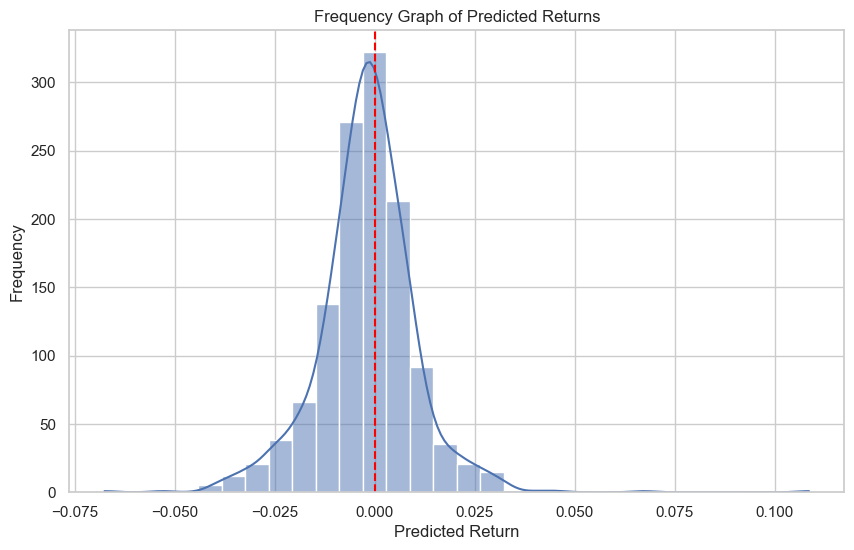

In [16]:
# Best Catboost test - 101α
# Train the best CatBoost model with the best parameters found
# Create an instance of the model
# Load the best CatBoost model
ca_alpha_model = joblib.load('catboost_alpha_model.pkl')  # Update the path as necessary

# Make predictions on the test set
predictions = ca_alpha_model.predict(X_test_alpha)-0.003

winning_trades = 0
losing_trades = 0

trading_options = len(y_test_alpha)
trades_made = np.sum(predictions > 0)  # Count of predicted returns greater than 0
trades = predictions[predictions>0]
winning_trades = np.sum((predictions > 0) & (y_test_alpha > 0))  # Count of winning trades
losing_trades = np.sum((predictions > 0) & (y_test_alpha < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading Options:", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)


# Set the style
sns.set(style="whitegrid")

# Draw a frequency graph of the predicted returns
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=30, kde=True)
plt.title('Frequency Graph of Predicted Returns')
plt.xlabel('Predicted Return')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line at zero return
plt.show()

In [13]:
# For CatBoost - 101a
# Calculate MAE
mae = np.mean(np.abs(y_test_alpha - predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_alpha - predictions) / y_test_alpha)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_alpha - predictions)) / np.sum(np.abs(y_test_alpha)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.011651820103738065
Mean Absolute Percentage Error (MAPE): 249.44328489321032
Weighted Mean Absolute Percentage Error (WMAPE): 89.23817838395814


In [27]:
# Find Best XGboost - 101α

X = X_train_alpha
y = y_train_alpha 

# Define the objective function for Bayesian optimization
def xgboost_evaluate(max_depth, learning_rate, n_estimators):
    model = XGBRegressor(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        objective='reg:squarederror',
        verbosity=0
    )
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and calculate RMSE
    predictions = model.predict(X_test_alpha)
    rmse = mean_squared_error(y_test_alpha, predictions, squared=False)  # RMSE
    return -rmse  # Negative because we want to minimize RMSE

# Define the parameter bounds for optimization
pbounds = {
    'max_depth': (3, 10),  # bounds for max_depth
    'learning_rate': (0.01, 0.3),  # bounds for learning rate
    'n_estimators': (50, 500)  # bounds for n_estimators
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=xgboost_evaluate,
    pbounds=pbounds,
    random_state=1
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best parameters found: ", optimizer.max)

# Extract the best parameters from the optimizer
best_params = optimizer.max['params']

# Train the best model using the optimal parameters
best_model = XGBRegressor(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    objective='reg:squarederror',
    verbosity=0
)

# Fit the model on the training data
best_model.fit(X_train_alpha, y_train_alpha)

# Save the model to a file
model_filename = 'xgboost_alpha_model.pkl' 
joblib.dump(best_model, model_filename)

# Confirm that the model has been saved
print(f"Best model saved as {model_filename}")

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 1         | -0.01771  | 0.1309    | 8.042     | 50.05     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 2         | -0.01724  | 0.09768   | 4.027     | 91.55     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 3         | -0.01761  | 0.06402   | 5.419     | 228.5     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 4         | -0.01783  | 0.1663    | 5.934     | 358.3     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 5         | -0.01752  | 0.06929   | 9.147     | 62.32     |
| 6         | -0.01763  | 0.2679    | 4.063     | 91.93     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 7         | -0.01761  | 0.1644    | 8.512     | 128.7     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 8         | -0.01797  | 0.1828    | 4.827     | 386.0     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 9         | -0.01747  | 0.07598   | 4.089     | 476.3     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 10        | -0.01789  | 0.2206    | 8.1       | 137.6     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 11        | -0.01733  | 0.1176    | 3.982     | 91.81     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 12        | -0.01827  | 0.2871    | 7.648     | 261.8     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 13        | -0.0179   | 0.1517    | 8.888     | 490.6     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 14        | -0.01724  | 0.2137    | 4.206     | 91.06     |
| 15        | -0.01784  | 0.02362   | 3.882     | 91.03     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 16        | -0.01792  | 0.2064    | 6.835     | 222.4     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 17        | -0.0172   | 0.05082   | 3.976     | 192.6     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 18        | -0.01731  | 0.08946   | 8.35      | 80.09     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 19        | -0.01724  | 0.0853    | 3.77      | 192.7     |
| 20        | -0.01731  | 0.1835    | 3.789     | 102.5     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 21        | -0.01787  | 0.188     | 6.902     | 344.1     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 22        | -0.01731  | 0.01488   | 4.808     | 410.3     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 23        | -0.01781  | 0.1006    | 6.824     | 422.0     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 24        | -0.0172   | 0.1258    | 4.282     | 91.52     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 25        | -0.01832  | 0.2743    | 7.359     | 486.2     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 26        | -0.01728  | 0.03373   | 3.423     | 192.3     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 27        | -0.01727  | 0.07671   | 3.454     | 366.7     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 28        | -0.01728  | 0.09481   | 3.87      | 192.1     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 29        | -0.0174   | 0.1474    | 4.711     | 90.87     |
| 30        | -0.01774  | 0.2534    | 5.93      | 183.2     |
Best parameters found:  {'target': -0.017202213598110423, 'params': {'learning_rate': 0.12584117842264944, 'max_depth': 4.281890051085153, 'n_estimators': 91.5191352332648}}
Best model saved as xgboost_alpha_model.pkl


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Trading options: 1257
Trades Made: 477
Winning Trades: 348
Losing Trades: 129
Average Trade Return: 0.006690551
Total Trade Return: 3.191393


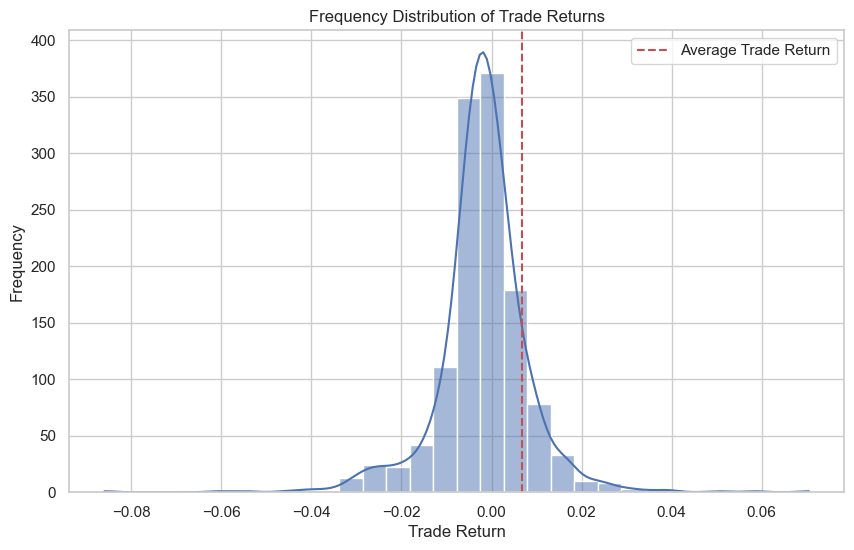

In [8]:
# Best XGBoost test -101a

# Make predictions on the test set

# Load the best XGBoost model
xgboost_alpha_model = joblib.load('xgboost_alpha_model.pkl')  # Update the path as necessary
xb_alpha_predictions = xgboost_alpha_model.predict(X_test_alpha) - 0.003


# Assuming predictions are the returns from trades
# Initialize counts
winning_trades = 0
losing_trades = 0

trading_options = len(y_test_alpha)
trades_made = np.sum(xb_alpha_predictions > 0)  # Count of predicted returns greater than 0
trades = xb_alpha_predictions[xb_alpha_predictions>0]
winning_trades = np.sum((xb_alpha_predictions > 0) & (y_test_alpha > 0))  # Count of winning trades
losing_trades = np.sum((xb_alpha_predictions > 0) & (y_test_alpha < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options:", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)

# Set the style
sns.set(style="whitegrid")

# Create a frequency graph of the trade returns
plt.figure(figsize=(10, 6))
sns.histplot(xb_alpha_predictions, bins=30, kde=True)
plt.title('Frequency Distribution of Trade Returns')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.axvline(average_trade_return, color='r', linestyle='--', label='Average Trade Return')
plt.legend()
plt.show()

In [10]:
# Best XGBoost - 101a
# Calculate MAE
mae = np.mean(np.abs(y_test_alpha - xb_alpha_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_alpha - xb_alpha_predictions) / y_test_alpha)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_alpha - xb_alpha_predictions)) / np.sum(np.abs(y_test_alpha)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.011226398360758791
Mean Absolute Percentage Error (MAPE): 226.17583301029555
Weighted Mean Absolute Percentage Error (WMAPE): 85.97998686963673


In [29]:
#  Find lightgbm best params -101α

X_train = X_train_alpha
y_train = y_train_alpha
# Define the objective function for Bayesian optimization
def lgbm_evaluate(num_leaves, learning_rate, n_estimators):
    model = lgb.LGBMRegressor(
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        objective='regression'
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the training set (or validation set if available)
    predictions = model.predict(X_train)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predictions))  # Calculate RMSE
    return -rmse  # Negative because we want to minimize RMSE

# Define the parameter bounds for optimization
pbounds = {
    'num_leaves': (20, 100),  # bounds for num_leaves
    'learning_rate': (0.01, 0.3),  # bounds for learning rate
    'n_estimators': (50, 500)  # bounds for n_estimators
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=lgbm_evaluate,
    pbounds=pbounds,
    random_state=1
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best parameters found: ", optimizer.max)

# Extract the best parameters from the optimizer
best_params = optimizer.max['params']

# Train the best model using the optimal parameters
best_model = lgb.LGBMRegressor(
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    objective='regression'
)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Save the model to a file
model_filename = 'lightgbm_alpha_model.pkl' 
joblib.dump(best_model, model_filename)

# Confirm that the model has been saved
print(f"Best model saved as {model_filename}")

|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10955
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 43
[LightGBM] [Info] Start training from score 0.000837
| 1         | -0.005354 | 0.1309    | 374.1     | 20.01     |
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10955
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 43
[LightGBM] [Info] Start training from score 0.000837
| 2         | -0.009774 | 0.09768   | 116.0     | 27.39     |
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

Trading options: 1257
Trades Made: 525
Winning Trades: 359
Losing Trades: 166
Average Trade Return: 0.009328911004203261
Total Trade Return: 4.897678277206713


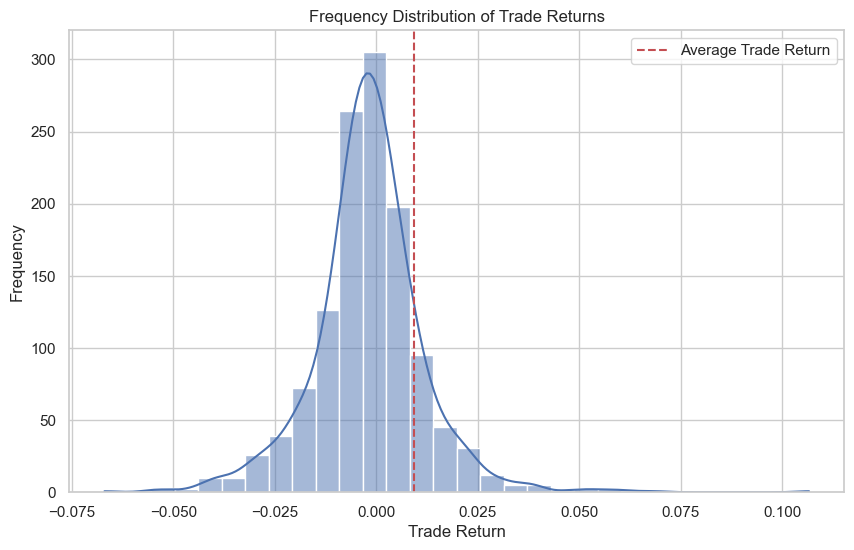

In [11]:
# Best Lightgbm test -101a

# Make predictions on the test set

# Load the best LightGBM model
lightgbm_alpha_model = joblib.load('lightgbm_alpha_model.pkl')  # Update the path as necessary
l_alpha_predictions = lightgbm_alpha_model.predict(X_test_alpha) - 0.003

# Assuming predictions are the returns from trades
# Initialize counts
winning_trades = 0
losing_trades = 0

trading_options = len(y_test_alpha)
trades_made = np.sum(l_alpha_predictions > 0)  # Count of predicted returns greater than 0
trades = l_alpha_predictions[l_alpha_predictions>0]
winning_trades = np.sum((l_alpha_predictions > 0) & (y_test_alpha > 0))  # Count of winning trades
losing_trades = np.sum((l_alpha_predictions > 0) & (y_test_alpha < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options:", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)

# Set the style
sns.set(style="whitegrid")

# Create a frequency graph of the trade returns
plt.figure(figsize=(10, 6))
sns.histplot(l_alpha_predictions, bins=30, kde=True)
plt.title('Frequency Distribution of Trade Returns')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.axvline(average_trade_return, color='r', linestyle='--', label='Average Trade Return')
plt.legend()
plt.show()

In [ ]:
# Best LightGBM -101a
# Calculate MAE
mae = np.mean(np.abs(y_test_alpha - l_alpha_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_alpha - l_alpha_predictions) / y_test_alpha)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_alpha - l_alpha_predictions)) / np.sum(np.abs(y_test_alpha)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

NameError: name 'l_alpha_predictions' is not defined

In [74]:
l_alpha_predictions

array([ 0.00115314,  0.00130906, -0.01577419, ..., -0.03430919,
        0.03208001,  0.01276886])

In [34]:
# Find Best Catboost params - 101α+genetic

X = X_train_combined  # Features (all α values)
y = y_train_combined  

# Define the objective function for Bayesian optimization
def catboost_evaluate(depth, learning_rate, iterations):
    Cat_alpha_model = CatBoostRegressor(
        depth=int(depth),
        learning_rate=learning_rate,
        iterations=int(iterations),
        verbose=0
    )
    
    # Train the model
    Cat_alpha_model.fit(X, y)
    
    # Evaluate the model (using RMSE as an example)
    return -Cat_alpha_model.get_best_score()['learn']['RMSE']  # Negative because we want to maximize

# Define the parameter bounds for optimization
pbounds = {
    'depth': (4, 10),  # bounds for depth
    'learning_rate': (0.01, 0.3),  # bounds for learning rate
    'iterations': (100, 1000)  # bounds for iterations
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=catboost_evaluate,
    pbounds=pbounds,
    random_state=1
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best parameters found: ", optimizer.max)


best_params = optimizer.max['params']
best_model = CatBoostRegressor(
    depth=int(best_params['depth']),
    learning_rate=best_params['learning_rate'],
    iterations=int(best_params['iterations']),
    verbose=0
)
# Fit the model on the training data
best_model.fit(X_train_combined, y_train_combined)

# Save the model to a file
model_filename = 'catboost_combine_model.pkl' 
joblib.dump(best_model, model_filename)

# Confirm that the model has been saved
print(f"Best model saved as {model_filename}")

|   iter    |  target   |   depth   | iterat... | learni... |
-------------------------------------------------------------
| 1         | -0.000729 | 6.502     | 748.3     | 0.01003   |
| 2         | -0.000837 | 5.814     | 232.1     | 0.03678   |
| 3         | -0.000261 | 5.118     | 411.0     | 0.1251    |
| 4         | -8.334e-0 | 7.233     | 477.3     | 0.2087    |
| 5         | -0.000452 | 5.227     | 890.3     | 0.01794   |
| 6         | -0.000141 | 8.569     | 472.2     | 0.1162    |
| 7         | -0.000165 | 4.439     | 518.9     | 0.2136    |
| 8         | -0.000170 | 9.832     | 350.7     | 0.1179    |
| 9         | -0.000312 | 9.917     | 602.9     | 0.02403   |
| 10        | -2.206e-0 | 9.331     | 999.9     | 0.29      |
| 11        | -0.000124 | 4.35      | 963.0     | 0.1535    |
| 12        | -0.00156  | 4.99      | 100.0     | 0.04535   |
| 13        | -0.000367 | 4.46      | 665.1     | 0.04564   |
| 14        | -0.000506 | 4.152     | 305.5     | 0.09152   |
| 15    

Trading options: 1257
Trades Made: 524
Winning Trades: 524
Losing Trades: 0
Average Trade Return: 0.01366095343565559
Total Trade Return: 7.158339600283529


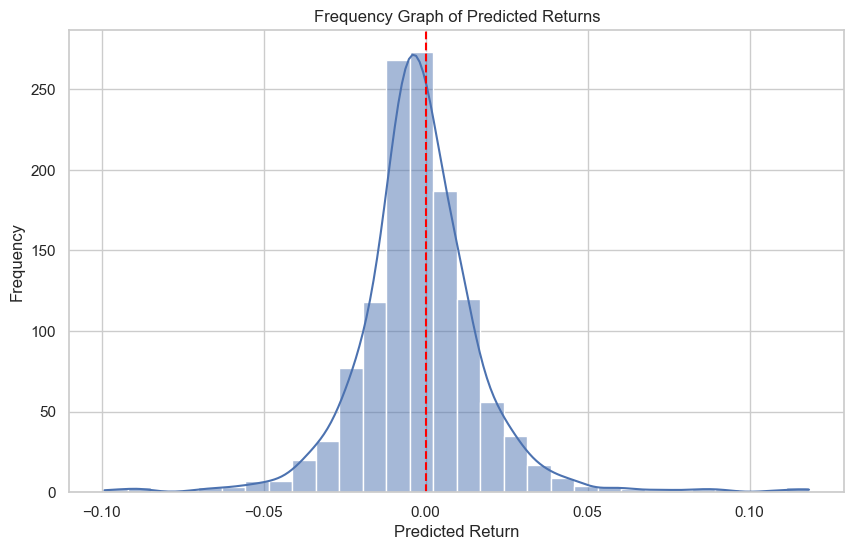

In [ ]:
# Best Catboost test-101α+genetic

# Load the best Catboost model
ca_co_model = joblib.load('catboost_combine_model.pkl')  
ca_co_predictions = ca_co_model.predict(X_test_combined) - 0.003


winning_trades = 0
losing_trades = 0

trading_options = len(y_test_combined)
trades_made = np.sum(ca_co_predictions > 0)  # Count of predicted returns greater than 0
trades = ca_co_predictions[ca_co_predictions>0]
winning_trades = np.sum((ca_co_predictions > 0) & (y_test_combined > 0))  # Count of winning trades
losing_trades = np.sum((ca_co_predictions > 0) & (y_test_combined < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options:", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)


# Set the style
sns.set(style="whitegrid")

# Draw a frequency graph of the predicted returns
plt.figure(figsize=(10, 6))
sns.histplot(ca_co_predictions, bins=30, kde=True)
plt.title('Frequency Graph of Predicted Returns')
plt.xlabel('Predicted Return')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')  # Line at zero return
plt.show()

In [7]:
# Best Catboost - 101α+genetic
# Calculate MAE
mae = np.mean(np.abs(y_test_combined - ca_co_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_combined - ca_co_predictions) / y_test_combined)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_combined - ca_co_predictions)) / np.sum(np.abs(y_test_combined)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.003162896772082143
Mean Absolute Percentage Error (MAPE): 125.04879630954939
Weighted Mean Absolute Percentage Error (WMAPE): 24.22378167910107


In [25]:
#Find best XGboost params-101α+genetic

X = X_train_combined
y = y_train_combined 

# Define the objective function for Bayesian optimization
def xgboost_evaluate(max_depth, learning_rate, n_estimators):
    model = XGBRegressor(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        objective='reg:squarederror',
        verbosity=0
    )
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and calculate RMSE
    predictions = model.predict(X_test_combined)
    rmse = mean_squared_error(y_test_combined, predictions, squared=False)  # RMSE
    return -rmse  # Negative because we want to minimize RMSE

# Define the parameter bounds for optimization
pbounds = {
    'max_depth': (3, 10),  # Example bounds for max_depth
    'learning_rate': (0.01, 0.3),  # Example bounds for learning rate
    'n_estimators': (50, 500)  # Example bounds for n_estimators
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=xgboost_evaluate,
    pbounds=pbounds,
    random_state=1
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best parameters found: ", optimizer.max)

# Extract the best parameters from the optimizer
best_params = optimizer.max['params']

# Train the best model using the optimal parameters
best_model = XGBRegressor(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    objective='reg:squarederror',
    verbosity=0
)

# Fit the model on the training data
best_model.fit(X_train_combined, y_train_combined)

# Save the model to a file
model_filename = 'xgboost_combine_model.pkl' 
joblib.dump(best_model, model_filename)

# Confirm that the model has been saved
print(f"Best model saved as {model_filename}")

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 1         | -0.002356 | 0.1309    | 8.042     | 50.05     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 2         | -0.002187 | 0.09768   | 4.027     | 91.55     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 3         | -0.002447 | 0.06402   | 5.419     | 228.5     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 4         | -0.002598 | 0.1663    | 5.934     | 358.3     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 5         | -0.002486 | 0.06929   | 9.147     | 62.32     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 6         | -0.002305 | 0.2679    | 4.063     | 91.93     |
| 7         | -0.00196  | 0.05423   | 3.818     | 91.02     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 8         | -0.001892 | 0.289     | 3.247     | 90.44     |
| 9         | -0.002247 | 0.1543    | 4.144     | 89.51     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 10        | -0.002318 | 0.1949    | 8.866     | 127.1     |
| 11        | -0.001858 | 0.08688   | 3.173     | 90.75     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 12        | -0.002178 | 0.2188    | 4.012     | 399.5     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 13        | -0.002385 | 0.1861    | 6.296     | 397.8     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 14        | -0.002202 | 0.05312   | 4.357     | 402.2     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 15        | -0.002322 | 0.1179    | 5.587     | 405.0     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 16        | -0.002292 | 0.1738    | 9.511     | 449.2     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 17        | -0.002175 | 0.1668    | 4.437     | 287.0     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 18        | -0.002478 | 0.143     | 5.4       | 284.9     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 19        | -0.0019   | 0.1152    | 3.721     | 289.0     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 20        | -0.002343 | 0.2929    | 4.246     | 290.1     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 21        | -0.002028 | 0.2732    | 3.01      | 288.3     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 22        | -0.002163 | 0.2297    | 4.737     | 288.4     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 23        | -0.002507 | 0.01046   | 3.022     | 289.5     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 24        | -0.001945 | 0.1412    | 3.947     | 288.4     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 25        | -0.002089 | 0.2271    | 3.273     | 287.5     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 26        | -0.001883 | 0.2759    | 3.02      | 89.67     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 27        | -0.001728 | 0.09413   | 3.158     | 91.43     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 28        | -0.001843 | 0.1936    | 3.277     | 87.93     |


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


| 29        | -0.001865 | 0.2896    | 3.177     | 88.75     |
| 30        | -0.00209  | 0.2576    | 3.097     | 86.93     |
Best parameters found:  {'target': -0.0017279964340613482, 'params': {'learning_rate': 0.09412975216347422, 'max_depth': 3.157671007250215, 'n_estimators': 91.42692637353748}}
Best model saved as xgboost_combine_model.pkl


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Trading options: 1257
Trades Made: 517
Winning Trades: 517
Losing Trades: 0
Average Trade Return: 0.013926967
Total Trade Return: 7.200242


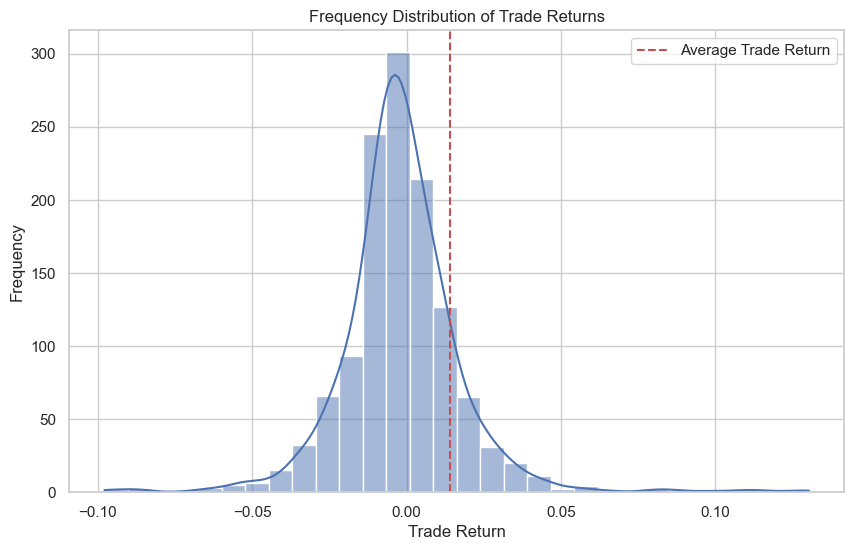

In [ ]:
# Best XGBoost test - 101a+genetic

# Make predictions on the test set

# Load the best XGBoost model
xgboost_co_model = joblib.load('xgboost_combine_model.pkl')  
xb_co_predictions = xgboost_co_model.predict(X_test_combined) - 0.003

# Assuming predictions are the returns from trades
# Initialize counts
winning_trades = 0
losing_trades = 0

trading_options = len(y_test_combined)
trades_made = np.sum(xb_co_predictions > 0)  # Count of predicted returns greater than 0
trades = xb_co_predictions[xb_co_predictions>0]
winning_trades = np.sum((xb_co_predictions > 0) & (y_test_combined > 0))  # Count of winning trades
losing_trades = np.sum((xb_co_predictions > 0) & (y_test_combined < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options:", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)

# Set the style
sns.set(style="whitegrid")

# Create a frequency graph of the trade returns
plt.figure(figsize=(10, 6))
sns.histplot(xb_co_predictions, bins=30, kde=True)
plt.title('Frequency Distribution of Trade Returns')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.axvline(average_trade_return, color='r', linestyle='--', label='Average Trade Return')
plt.legend()
plt.show()



In [9]:
# Best XGBoost - 101a+genetic
# Calculate MAE
mae = np.mean(np.abs(y_test_combined - xb_co_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_combined - xb_co_predictions) / y_test_combined)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_combined - xb_co_predictions)) / np.sum(np.abs(y_test_combined)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.003121612073683922
Mean Absolute Percentage Error (MAPE): 124.72169305370502
Weighted Mean Absolute Percentage Error (WMAPE): 23.90759319975728


In [31]:
# Find best lightgbm params - 101α+genetic

X_train = X_train_combined
y_train = y_train_combined
# Define the objective function for Bayesian optimization
def lgbm_evaluate(num_leaves, learning_rate, n_estimators):
    model = lgb.LGBMRegressor(
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        objective='regression'
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the training set (or validation set if available)
    predictions = model.predict(X_train)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_train, predictions))  # Calculate RMSE
    return -rmse  # Negative because we want to minimize RMSE

# Define the parameter bounds for optimization
pbounds = {
    'num_leaves': (20, 100),  # bounds for num_leaves
    'learning_rate': (0.01, 0.3),  # bounds for learning rate
    'n_estimators': (50, 500)  # bounds for n_estimators
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=lgbm_evaluate,
    pbounds=pbounds,
    random_state=1
)

# Run the optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best parameters found
print("Best parameters found: ", optimizer.max)

# Extract the best parameters from the optimizer
best_params = optimizer.max['params']

# Train the best model using the optimal parameters
best_model = lgb.LGBMRegressor(
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    objective='regression'
)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Save the model to a file
model_filename = 'lightgbm_combine_model.pkl'  
joblib.dump(best_model, model_filename)

# Confirm that the model has been saved
print(f"Best model saved as {model_filename}")

|   iter    |  target   | learni... | n_esti... | num_le... |
-------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12995
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 51
[LightGBM] [Info] Start training from score 0.000837
| 1         | -0.000385 | 0.1309    | 374.1     | 20.01     |
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12995
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 51
[LightGBM] [Info] Start training from score 0.000837
| 2         | -0.001557 | 0.09768   | 116.0     | 27.39     |
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

Trading options: 1257
Trades Made: 520
Winning Trades: 520
Losing Trades: 0
Average Trade Return: 0.013899116072053831
Total Trade Return: 7.227540357467992


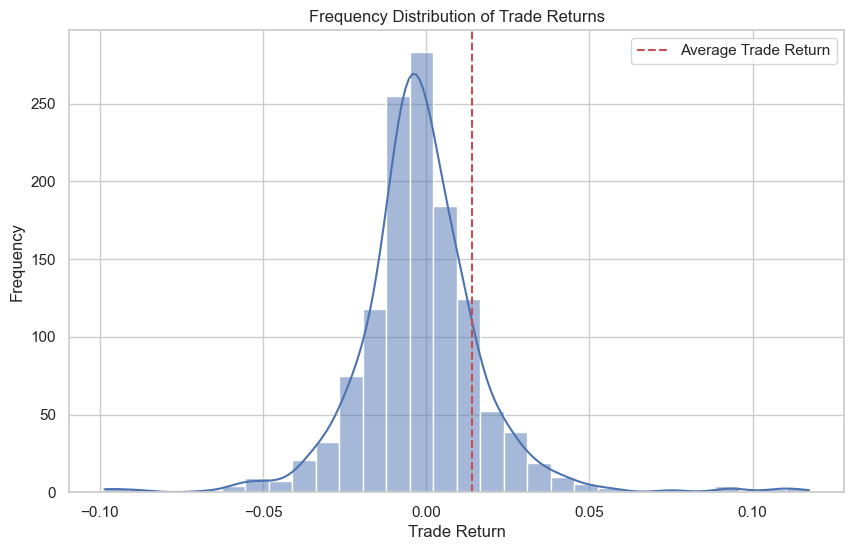

In [ ]:
# Best Lightgbm test -101a+genetic

# Make predictions on the test set

# Load the best LightGBM model
lightgbm_co_model = joblib.load('lightgbm_combine_model.pkl')  
l_co_predictions = lightgbm_co_model.predict(X_test_combined) - 0.003

# Assuming predictions are the returns from trades
# Initialize counts
winning_trades = 0
losing_trades = 0

trading_options = len(y_test_combined)
trades_made = np.sum(l_co_predictions > 0)  # Count of predicted returns greater than 0
trades = l_co_predictions[l_co_predictions>0]
winning_trades = np.sum((l_co_predictions > 0) & (y_test_combined > 0))  # Count of winning trades
losing_trades = np.sum((l_co_predictions > 0) & (y_test_combined < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options:", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)

# Set the style
sns.set(style="whitegrid")

# Create a frequency graph of the trade returns
plt.figure(figsize=(10, 6))
sns.histplot(l_co_predictions, bins=30, kde=True)
plt.title('Frequency Distribution of Trade Returns')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.axvline(average_trade_return, color='r', linestyle='--', label='Average Trade Return')
plt.legend()
plt.show()

In [12]:
# Best Lightgbm -101a+genetic
# Calculate MAE
mae = np.mean(np.abs(y_test_combined - l_co_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_combined - l_co_predictions) / y_test_combined)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_combined - l_co_predictions)) / np.sum(np.abs(y_test_combined)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.003194925350818826
Mean Absolute Percentage Error (MAPE): 124.32933526845049
Weighted Mean Absolute Percentage Error (WMAPE): 24.469080009940544


In [13]:
# Majority vote prediction -101α

# Split the data into training and testing sets
X_train = X_train_alpha
y_train = y_train_alpha
X_test = X_test_alpha
y_test = y_test_alpha

# Initialize the models
xgb_model = joblib.load('xgboost_alpha_model.pkl') 
cat_model = joblib.load('catboost_alpha_model.pkl') 
lgb_model = joblib.load('lightgbm_alpha_model.pkl') 

# Fit the models
xgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)
cat_predictions = cat_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)

# Combine predictions using voting
voting_model = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('cat', cat_model),
    ('lgb', lgb_model)
])
voting_model.fit(X_train, y_train)  # Fit on the training data
final_alpha_predictions = voting_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10955
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 43
[LightGBM] [Info] Start training from score 0.000837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10955
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 43
[LightGBM] [Info] Start training from score 0.000837


Trading options 1257
Trades Made: 518
Winning Trades: 376
Losing Trades: 142
Average Trade Return: 0.007220195978453079
Total Trade Return: 3.7400615168386953


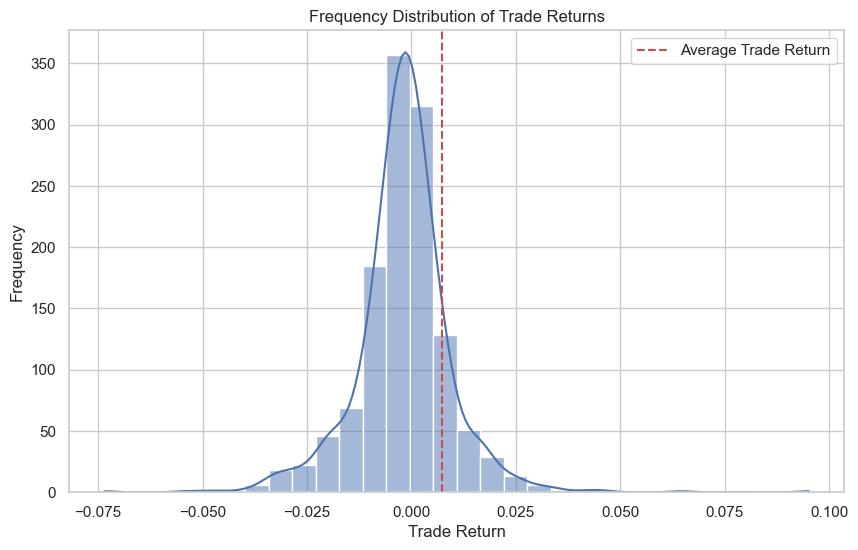

In [14]:
# Display α101 results 
# Initialize counts
winning_trades = 0
losing_trades = 0

final_alpha_predictions = final_alpha_predictions - 0.003
trading_options = len(y_test_alpha)
trades_made = np.sum(final_alpha_predictions > 0)  # Count of predicted returns greater than 0
trades = final_alpha_predictions[final_alpha_predictions>0]
winning_trades = np.sum((final_alpha_predictions > 0) & (y_test_alpha > 0))  # Count of winning trades
losing_trades = np.sum((final_alpha_predictions > 0) & (y_test_alpha < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)

# Set the style
sns.set(style="whitegrid")

# Create a frequency graph of the trade returns
plt.figure(figsize=(10, 6))
sns.histplot(final_alpha_predictions, bins=30, kde=True)
plt.title('Frequency Distribution of Trade Returns')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.axvline(average_trade_return, color='r', linestyle='--', label='Average Trade Return')
plt.legend()
plt.show()

In [15]:
# Majority vote -101α
# Calculate MAE
mae = np.mean(np.abs(y_test_alpha - final_alpha_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_alpha - final_alpha_predictions) / y_test_alpha)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_alpha - final_alpha_predictions)) / np.sum(np.abs(y_test_alpha)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.011158726495154727
Mean Absolute Percentage Error (MAPE): 230.73221018019257
Weighted Mean Absolute Percentage Error (WMAPE): 85.46170612374596


In [ ]:
# Majority vote prediction -101α+genetic

# Split the data into training and testing sets
X_train = X_train_combined
y_train = y_train_combined
X_test = X_test_combined
y_test = y_test_combined

# Initialize the models
xgb_model = joblib.load('xgboost_combine_model.pkl') 
cat_model = joblib.load('catboost_combine_model.pkl') 
lgb_model = joblib.load('lightgbm_combine_model.pkl') 

# Fit the models
xgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)
cat_predictions = cat_model.predict(X_test)
lgb_predictions = lgb_model.predict(X_test)

# Combine predictions using voting
voting_model = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('cat', cat_model),
    ('lgb', lgb_model)
])
voting_model.fit(X_train, y_train)  # Fit on the training data


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12995
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 51
[LightGBM] [Info] Start training from score 0.000837
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12995
[LightGBM] [Info] Number of data points in the train set: 5028, number of used features: 51
[LightGBM] [Info] Start training from score 0.000837


VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constrain...
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=91,
                                          n_jobs=None, num_parallel_tree=None, ...)),
                            ('cat',
                             <catboost.core.CatBoostRegressor object at 0x000002244EF63A70>),
                            ('lgb',
                             LGBMRegressor(learning_rate=0.23043821080751584,
                                           n_estimators=499, num_leaves=99,
                                           objective='regression'))])

Trading options 1257
Trades Made: 520
Winning Trades: 520
Losing Trades: 0
Average Trade Return: 0.013836520520263311
Total Trade Return: 7.194990670536922


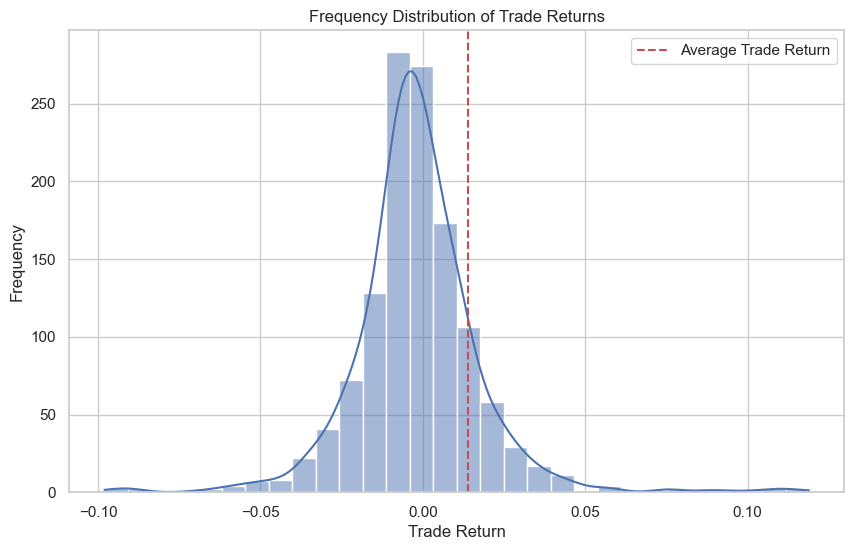

In [15]:
# display α101+genetic results
final_predictions = voting_model.predict(X_test) - 0.003
# Initialize counts
winning_trades = 0
losing_trades = 0

trading_options = len(y_test_combined)
trades_made = np.sum(final_predictions > 0)  # Count of predicted returns greater than 0
trades = final_predictions[final_predictions>0]
winning_trades = np.sum((final_predictions > 0) & (y_test_combined > 0))  # Count of winning trades
losing_trades = np.sum((final_predictions > 0) & (y_test_combined < 0))  # Count of losing trades
average_trade_return = trades.mean()  # Average return per trade
total_trade_return = trades.sum()  # Total return from all trades

# Print the results
print("Trading options", trading_options)
print("Trades Made:", trades_made)
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Average Trade Return:", average_trade_return)
print("Total Trade Return:", total_trade_return)

# Set the style
sns.set(style="whitegrid")

# Create a frequency graph of the trade returns
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions, bins=30, kde=True)
plt.title('Frequency Distribution of Trade Returns')
plt.xlabel('Trade Return')
plt.ylabel('Frequency')
plt.axvline(average_trade_return, color='r', linestyle='--', label='Average Trade Return')
plt.legend()
plt.show()

In [16]:
# Majority vote -101α+genetic
# Calculate MAE
mae = np.mean(np.abs(y_test_combined - final_predictions))

# Calculate MAPE
mape = np.mean(np.abs((y_test_combined - final_predictions) / y_test_combined)) * 100

# Calculate WMAPE
wmape = np.sum(np.abs(y_test_combined - final_predictions)) / np.sum(np.abs(y_test_combined)) * 100

# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Weighted Mean Absolute Percentage Error (WMAPE):", wmape)

Mean Absolute Error (MAE): 0.003138113799603642
Mean Absolute Percentage Error (MAPE): 124.6397946911866
Weighted Mean Absolute Percentage Error (WMAPE): 24.0339755115469


In [ ]:
# Display the params optimization
# Load the trained model
best_model = joblib.load('lightgbm_combine_model.pkl') 

# Access the model's parameters
model_params = best_model.get_params()

# Print the model parameters
print("Model Parameters:")
for param, value in model_params.items():
    print(f"{param}: {value}")

Model Parameters:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.23043821080751584
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 499
n_jobs: None
num_leaves: 99
objective: regression
random_state: None
reg_alpha: 0.0
reg_lambda: 0.0
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0
